#### ANLY 580 - NLP for Data Analytics Fall Semester 2019

### This notebook relies on the preprocessing performed in the topic modeling using LDA notebook. The dictionary and corpus preprocessing is re-used in this notebook to demonstrate topic modeling using Non-negative Matrix Factorization (NNMF)

In [1]:
import os
import pandas as pd
import numpy as np

import gensim
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel
from gensim.models.nmf import Nmf

from nltk.corpus import stopwords
import string
import re
import pprint

from collections import OrderedDict

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Modify these parmeters for the local directory structre where the data is located. 

data_file_path = "data"
TEMP_FOLDER = "backup"

In [3]:
# Read in the parsed_tweets dataframe from the ldamodel
parsed_tweets_types = {'msgid':str, 'topic':str, 'sentiment':str, 'Tweet':list}
parsed_tweets = pd.read_csv(os.path.join(data_file_path, "parsed_tweets.csv"),
                            sep="\t",
                            index_col = 0,
                            dtype={'msgid':str, 'topic':str, 'sentiment':str, 'Tweet':str},
                            converters={"Tweet": lambda x: x.strip("[]").replace("'","").split(", ")})
parsed_tweets.head(15)

,msgid,topic,sentiment,Tweet
0,628949369883000832,@microsoft,negative,"[dear, @microsoft, newooffice, mac, great, lyn..."
1,628976607420645377,@microsoft,negative,"[@microsoft, make, system, ""doesnt"", eat, frig..."
2,629023169169518592,@microsoft,negative,"[may, ignorant, issue, celebrate, ""@microsofts..."
3,629179223232479232,@microsoft,negative,"[thanks, @microsoft, may, switching, @apple]"
4,629226490152914944,@microsoft,positive,"[microsoft, may, prefer, gaming, branch, busin..."
5,629345637155360768,@microsoft,negative,"[@mikewolf, @microsoft, downgrading, let, #win..."
6,629394528336637953,@microsoft,negative,"[@microsoft, computer, error, #windowsfail, gu..."
7,629650766580609026,@microsoft,positive,"[ordered, ever, tablet, @microsoft, surface, p..."
8,629797991826722816,@microsoft,negative,"[attempting, reinstall, still, bricks, says, w..."
9,630159517058142208,@microsoft,positive,"[sunday, morning, quiet, day, time, welcome, #..."


In [4]:
parsed_tweets.tail(15)

,msgid,topic,sentiment,Tweet
4294,635599514556956672,metlife,positive,"[@mcivorrugby, neck, woods, next, week, fancy,..."
4295,635658990123360258,metlife,positive,"[prays, one, direction, come, metlife, birthda..."
4296,636324904258904065,metlife,positive,"[looks, like, going, see, phins, gillette, oct..."
4297,636714456546975744,metlife,positive,"[oney, thursday, friday, metlife, giants-jets,..."
4298,637340624031604736,metlife,negative,"[really, ""couldnt"", open, pitt, metlife, bosto..."
4299,637342059519680513,metlife,negative,"[still, bitter, ""didnt"", tweet, metlife, augus..."
4300,637691185100947456,metlife,positive,"[remember, buying, tickets, rowyso, last, year..."
4301,637874723288936448,metlife,positive,"[@zourrysscheese, hershey, tmh, americas, got,..."
4302,638382158420307968,metlife,positive,"[@uglyuni, mom, already, bought, tickets, sect..."
4303,638533993344864256,metlife,positive,"[schreier, financial, services, orange, city, ..."


In [5]:
human_topics = list(set(parsed_tweets['topic'].tolist()))
print(human_topics)

['@microsoft', 'ipad', 'kerry', 'magic mike xxl', 'hillary', 'iphone', 'beyonce', 'chelsea', 'hannibal', 'jurassic park', 'david beckham', 'grateful dead', 'ihop', 'jurassic world', 'disneyland', 'google+', 'jay-z', 'federer', 'apple watch', 'conor mcgregor', 'google', 'bobby jindal', 'ios', 'ibm', 'batman', 'juventus', 'bentley', 'game of thrones', 'ipod', 'jeb bush', 'joe biden', 'labor day', 'kurt cobain', 'lexus', 'messi', 'david cameron', 'bbc', 'galaxy note', 'bob marley', 'barca', 'justin', 'mariah carey', 'harper', 'angela merkel', 'fleetwood mac', 'donald trump', 'ac/dc', 'erdogan', 'arsenal', 'amazon prime', 'digi', 'eric church', 'madonna', 'metlife', 'bernie sanders', 'apple', 'chris brown', 'amazon', 'amazon prime day', 'harry potter']


In [6]:
# Load in the dictionary and corpus computed for the lda model.

dictionary = corpora.Dictionary.load(os.path.join(TEMP_FOLDER, 'semval.dict'))  # load from dictionary
corpus = corpora.MmCorpus(os.path.join(TEMP_FOLDER, 'semval.mm'))  # load from disk

In [7]:
# In NNMF factorization we will use term-frequency-inverse_document-frequency for weighting the term document matrix

tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model
corpus_tfidf = tfidf[corpus]      # step 2 -- use the model to transform vectors

In [8]:
# Change the total_topics number to examine impacts the number of topics has with NNMF

total_topics = 20
num_passes = 20

In [9]:
# Build the model

nmf = Nmf(corpus, id2word = dictionary, passes = 20, num_topics = total_topics)

In [10]:
#Show first n=10 important words in the topics:
nmf.show_topics(total_topics, num_words = 10)

[(0,
  '0.100*"go" + 0.051*"get" + 0.028*"disneyland" + 0.021*"don\'t" + 0.021*"it\'s" + 0.020*"want" + 0.013*"monday" + 0.011*"david" + 0.010*"wanna" + 0.010*"ihop"'),
 (1,
  '0.178*"night" + 0.044*"last" + 0.018*"saturday" + 0.013*"good" + 0.012*"tomorrow" + 0.008*"make" + 0.008*"fleetwood" + 0.008*"watching" + 0.008*"mac" + 0.008*"show"'),
 (2,
  '0.038*"david" + 0.038*"sun" + 0.035*"bob" + 0.034*"dc" + 0.034*"marley" + 0.033*"ac" + 0.023*"beckham" + 0.014*"cameron" + 0.013*"shining" + 0.008*"concert"'),
 (3,
  '0.136*"like" + 0.013*"day" + 0.010*"it\'s" + 0.009*"monday" + 0.008*"looks" + 0.008*"look" + 0.008*"feel" + 0.007*"marley" + 0.007*"bob" + 0.007*"people"'),
 (4,
  '0.057*"time" + 0.029*"know" + 0.019*"thursday" + 0.015*"trump" + 0.014*"jeb" + 0.014*"bush" + 0.014*"biden" + 0.013*"joe" + 0.013*"jurassic" + 0.011*"donald"'),
 (5,
  '0.195*"day" + 0.052*"prime" + 0.041*"amazon" + 0.031*"labor" + 0.022*"black" + 0.016*"today" + 0.013*"deals" + 0.010*"monday" + 0.008*"one" + 0.0

In [11]:
# Load the topic - term data into an pyton dictionary
data_nmf = {i: OrderedDict(nmf.show_topic(i,10)) for i in range(total_topics)}
#data_nmf

In [12]:
# Use the ordered dictionary to load the data into a dataframe
data_nmf = pd.DataFrame(data_nmf)
data_nmf = data_nmf.fillna(0).T
print(data_nmf.shape)

(20, 127)


In [13]:
data_nmf.head(20)

,go,get,disneyland,don't,it's,want,monday,david,wanna,ihop,...,right,sanders,chris,free,game,thrones,season,episode,back,start
0,0.099525,0.051417,0.028409,0.021297,0.020972,0.020254,0.013388,0.010604,0.010334,0.009613,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038358,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.010295,0.000000,0.008538,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010327,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6,0.000000,0.008428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.055253,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [14]:
# Run the original documents back thru the model to infer the distribution of topics 
# according to the nnmf model

topics = []
probs = []
max_to_show = 20

for k, i in enumerate(range(len(parsed_tweets['Tweet']))):
    bow = dictionary.doc2bow(parsed_tweets['Tweet'][i])
    doc_topics = nmf.get_document_topics(bow, minimum_probability = 0.01)
    topics_sorted = sorted(doc_topics, key = lambda x: x[1], reverse = True)
    topics.append(topics_sorted[0][0])
    probs.append("{}".format(topics_sorted[0][1]))
    
    # Dump out the topic and probability assignments for the first 20 documents
    if k < max_to_show:
        print("Document {}: {}".format(k, topics_sorted))

parsed_tweets['NMFtopic'] = pd.Series(topics)
parsed_tweets['NMFprob'] = pd.Series(probs)

Document 0: [(15, 0.38432691345805853), (12, 0.2850227410851694), (9, 0.08946042062782776), (8, 0.06877511848980797), (4, 0.05493718451213621), (1, 0.049723267104538484), (11, 0.027401052668703324), (0, 0.014321357014405083), (2, 0.013830074121271033), (18, 0.010480675810792931)]
Document 1: [(4, 0.8731802747881623), (9, 0.06525957002676899), (2, 0.03238545937795199), (3, 0.017782840604010204)]
Document 2: [(11, 0.9978438586285132)]
Document 3: [(11, 0.951391107342854), (4, 0.03862710082667658)]
Document 4: [(11, 0.7785115228881399), (4, 0.08103421179759422), (2, 0.03670135333949806), (3, 0.026875315529930405), (7, 0.025283045573189538), (1, 0.023867566104045224), (17, 0.015059308706900077)]
Document 5: [(4, 0.5744567922005218), (2, 0.10586816010150699), (15, 0.09473863237814478), (13, 0.08050226361879197), (3, 0.03497483944183231), (18, 0.02606180731903415), (11, 0.02601228538294707), (0, 0.02449497784744636), (7, 0.02025952240058434)]
Document 6: [(4, 0.53620570624853), (2, 0.1589090

In [15]:
# dump the topic assignments for the last document thru the previous loop

doc_topics

[(15, 0.9949973032339104)]

In [16]:
# Resort the dataframe according to the human annotated topic and nnmf topic
parsed_tweets.sort_values(['topic', 'NMFtopic'], ascending=[True, False], inplace=True)
parsed_tweets.head(20)

,msgid,topic,sentiment,Tweet,NMFtopic,NMFprob
66,639716079430967296,@microsoft,negative,"[@microsoft, game, evolve, available, monday, ...",18,0.4646813881898497
28,633694793852407808,@microsoft,positive,"[pax, prime, thursday, overloaded, @microsoft,...",16,0.461460569558493
0,628949369883000832,@microsoft,negative,"[dear, @microsoft, newooffice, mac, great, lyn...",15,0.38432691345805853
9,630159517058142208,@microsoft,positive,"[sunday, morning, quiet, day, time, welcome, #...",15,0.42741659090579676
31,634036617632546816,@microsoft,negative,"[@microsoft, @windows, daily, windows, updates...",15,0.40015509645362823
36,634364883040006144,@microsoft,negative,"[thought, @microsoft, retiring, lumia, line, g...",15,0.35536462542241054
44,635528136743092224,@microsoft,negative,"[spending, day, phone, @microsoft, wanted, spe...",15,0.683577157043686
50,636861074256592896,@microsoft,negative,"[hate, @adobe, u, crash, application, tho, @mi...",15,0.5177807889296167
56,638268341052948480,@microsoft,positive,"[startup, monday, right, way, apply, pitch, ba...",15,0.3635250318150788
70,640261386417897473,@microsoft,negative,"[@microsoft, ur, company, give, pounds, plus, ...",15,0.4871865135393281


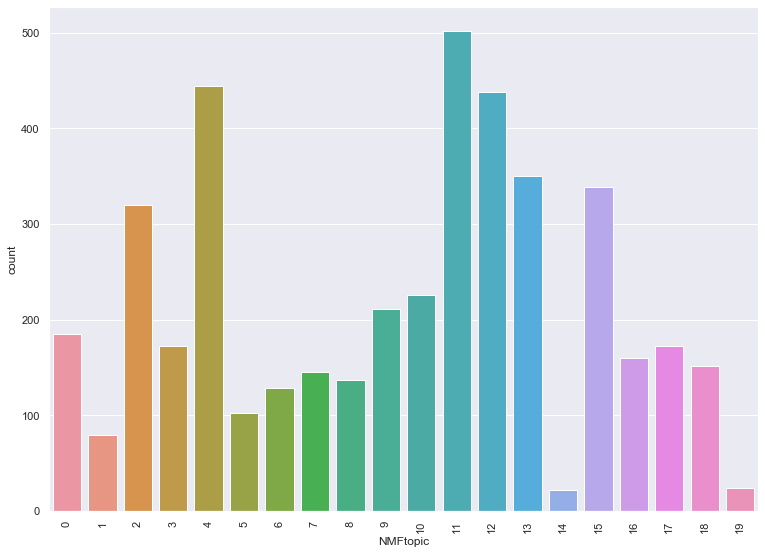

In [17]:
# Take a look at the distributions of human annotated topics in the data via a barplot

sns.set(rc={'figure.figsize':(12.7,9.27)})
by_topic = sns.countplot(x='NMFtopic', data=parsed_tweets)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

In [18]:
# Resort the dataframe according to the the nnmf assigned topic and the human annotated topic

parsed_tweets.sort_values(['NMFtopic', 'topic'], ascending=[True, True], inplace=True)
parsed_tweets.head(20)

,msgid,topic,sentiment,Tweet,NMFtopic,NMFprob
43,634926683284336640,@microsoft,negative,"[trying, get, @microsofthelps, @microsoft, @wi...",0,0.4587568648934183
476,641608077423329280,apple,positive,"[go, @tomiahonen, expect, ""apples"", big, event...",0,0.8312051207544048
483,641627937364512768,apple,positive,"[goosebumps, always, get, announcement, stream...",0,0.4920595039384687
606,640568943032279040,arsenal,positive,"[guess, main, teams, best, way, go, going, ars...",0,0.2578308168028188
612,640808820013465600,arsenal,positive,"[thoughts, turning, sat, whilst, ""theres"", obv...",0,0.43343297393706226
620,640998783489216512,arsenal,positive,"[@khaleel, yessir, leaving, try, get, ticket, ...",0,0.47495722042640026
629,641334333014474752,arsenal,positive,"[@ramzwi, @leutrimrexhaj, ""youre"", struggling,...",0,0.7454400174451797
638,641547796127088640,arsenal,negative,"[@jamesolley, gives, fuck, old, shit, arsenal,...",0,0.7525238073881128
646,637705438100746240,barca,positive,"[""lets"", go, barca, goal, half, ends]",0,0.9399307658584765
653,637764275944181760,barca,positive,"[@jodynotjodie, knackered, going, town, tomorr...",0,0.28556428849511983


In [19]:
# Resort the dataframe according to the the nnmf assigned topic and the assocoiated probability
parsed_tweets.sort_values(['NMFtopic', 'NMFprob'], ascending=[True, False], inplace=True)
parsed_tweets.head(20)

,msgid,topic,sentiment,Tweet,NMFtopic,NMFprob
1702,641476038766149633,disneyland,positive,"[go, disneyland, super, lame, lol]",0,0.9663617609082616
1698,641426682717581313,disneyland,positive,"[awkward, moment, @jccaylen, disneyland, ""your...",0,0.9602428797740091
1631,640283642195869696,disneyland,positive,"[want, life, go, disneyland, october, hallowee...",0,0.9528368968443613
1045,640829256382156800,beyonce,positive,"[jay, z, didnt, go, anywhere, near, beyonce, t...",0,0.950153886889063
646,637705438100746240,barca,positive,"[""lets"", go, barca, goal, half, ends]",0,0.9399307658584765
769,641479664838569984,batman,positive,"[sad, thing, learned, easter, march, friends, ...",0,0.9396692178801708
2892,641254971401502720,ihop,positive,"[want, go, ihop, ""fridays""]",0,0.9389127220890483
3151,625293292918456320,jay-z,negative,"[@marc_ryder, yeah, bro, ""its"", warning, shot,...",0,0.9350970173205863
2535,641007608548192256,harper,negative,"[tool, @joelsherman, fans, leaving, inning, wa...",0,0.9189417661932279
3094,639972676505837568,ipod,positive,"[stream, long, wanna, go, sleep, want, ipod, h...",0,0.9069459598422186


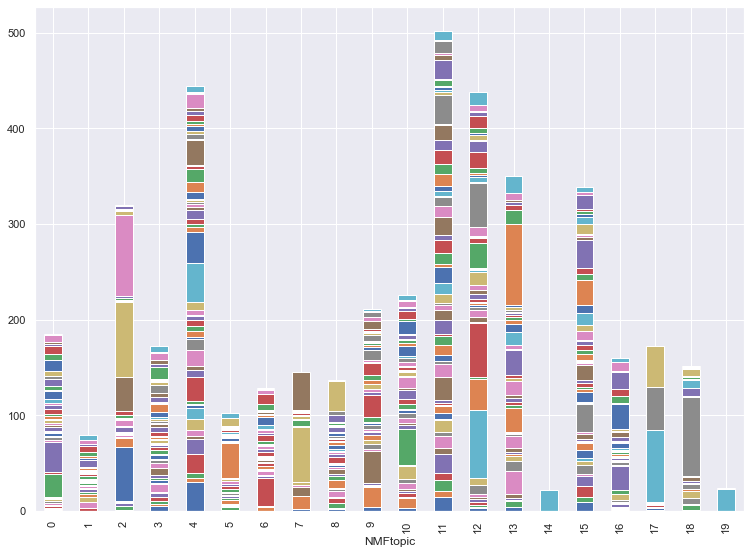

In [20]:
# What do the topic distrubtions look like relative to the original human annotated/tagged topics

df2 = parsed_tweets.groupby(['NMFtopic', 'topic'])['NMFtopic'].count().unstack('topic')
topic_mixture = df2[human_topics].plot(kind='bar', stacked=True, legend = False)

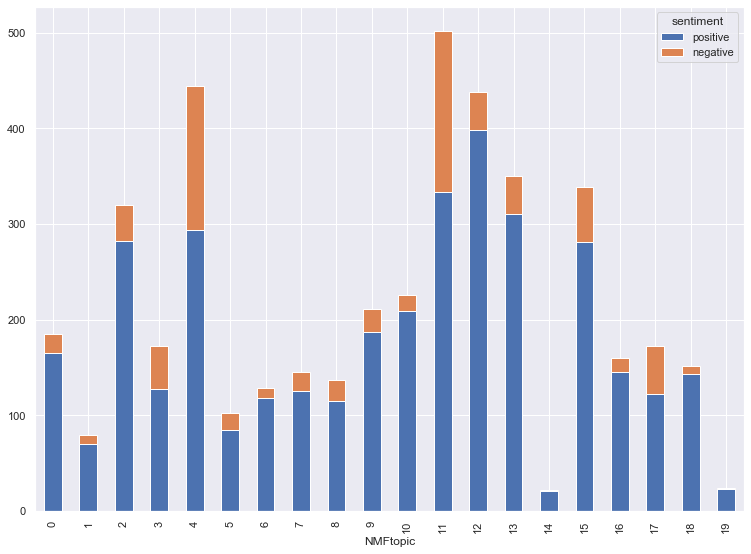

In [21]:
# What do the topic distrubtions look like relative to the original human annotated/tagged sentiment

human_sentiment = list(set(parsed_tweets['sentiment'].tolist()))
df2 = parsed_tweets.groupby(['NMFtopic', 'sentiment'])['NMFtopic'].count().unstack('sentiment')
topic_mixture = df2[human_sentiment].plot(kind='bar', stacked=True, legend = True)